# Histopathologic Cancer Detection

This project applies deep learning to the task of detecting cancer in histopathologic images of lymph node sections. The dataset, provided by [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview), contains 220,025 color images of size 96×96 pixels in `.tif` format. Each image is labeled as either 1 (cancerous) or 0 (non-cancerous), based on whether the central region of the patch contains tumor tissue. The test set consists of 57,458 unlabeled images, for which predictions must be submitted to Kaggle for evaluation. The competition metric is the Area Under the ROC Curve (AUC).

The goal of this notebook is to compare two modeling strategies for binary classification of these histopathology images:
1. A custom-built SimpleCNN trained from scratch, serving as a baseline model.  
2. A transfer learning approach with ResNet50, leveraging pretrained ImageNet features with fine-tuning.  

The notebook is organized into the following main sections:

1. Setup: Define constants, set random seeds for reproducibility, and prepare device configuration.  
2. Exploratory Data Analysis (EDA): Analyze statistical and structural properties of the images, including distributions of mean brightness, contrast, Shannon entropy, edge density, mean vs. brightness relationships, whole-image vs. center brightness, and per-channel statistics per class. These analyses help understand the dataset balance, variability, and differences between cancerous and non-cancerous samples.  
3. Model Training  
   - SimpleCNN: A lightweight CNN trained from scratch on the dataset.  
   - ResNet50 Transfer Learning: A deeper pretrained model fine-tuned for this task.  
4. Evaluation & Visualization: Assess models using ROC and Precision–Recall curves, confusion matrices, and validation metrics (loss, accuracy, AUC).  
5. Conclusion: Summarize findings, compare models side by side, and highlight the impact of transfer learning on performance.  

By following this workflow, the notebook demonstrates both the baseline performance of a simple CNN and the performance gains achieved through transfer learning. The final comparison provides insights into the trade-off between simplicity and model complexity for medical image classification tasks.

In [ ]:
import torch
import logging
import pandas as pd


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import torch.nn.functional as F
import torch.optim as optim
import random
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)

import math, time, copy
from torch.utils.data import Subset


from typing import Optional
from torch.amp import autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import shannon_entropy

In [54]:
from image_dataset import ImageDataset

### Note on `ImageDataset` Import

In this notebook, I use a custom `ImageDataset` class imported from a separate Python file:

```python
from image_dataset import ImageDataset
```

The reason for keeping this class outside the notebook is practical: when working with large datasets and multiple workers in PyTorch DataLoader, Jupyter notebooks can sometimes run into issues with multiprocessing. Defining the dataset class in a separate `.py` file ensures compatibility with multiple workers and improve the peformance.

For reference, the full implementation of the ImageDataset class is available [here](https://github.com/devmarkpro/histopathologic-cancer-detection/blob/main/image_dataset.py). I also include the code of the class in the following markdown cell for completeness:

```python
import os
from PIL import Image
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    """
    Custom Dataset for loading histopathological images and their labels.
    - data_type in {"train", "test"}:
        * "train": returns (image_tensor, label:int)
        * "test" : returns (image_tensor, id:str)
    Args:
        data_dir (str): Root directory of the dataset.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``.
        label_df (pd.DataFrame): DataFrame containing image filenames and their corresponding labels.
        data_type (str): Type of data to load, either "train" or "test".
    Returns:
        tuple: (image, label) where image is a transformed tensor and label is the corresponding
                label for the image.
    """

    def __init__(self, data_dir, transform, label_df=None, data_type: str = "train"):
        assert data_type in {"train", "test"}, "data_type must be 'train' or 'test'"
        self.transform = transform
        self.data_type = data_type

        folder = "test" if data_type == "test" else "train"
        images_path = os.path.join(data_dir, folder)
        file_names = sorted(
            [f for f in os.listdir(images_path) if f.lower().endswith(".tif")]
        )

        self.ids = [os.path.splitext(f)[0] for f in file_names]
        full_paths = [os.path.join(images_path, f) for f in file_names]

        if data_type == "test":
            # No labels for test; keep ids for CSV submissions
            self.labels = None
            # For test we store (path, id) tuples
            self.items = list(zip(full_paths, self.ids))
        else:
            # Train/val mode: require labels and keep (path, label) to stay compatible
            if label_df is None:
                raise ValueError("label_df must be provided when data_type='train'.")

            items = []
            ids_kept, labels = [], []
            for p, id_ in zip(full_paths, self.ids):
                if id_ in label_df.index:
                    y = int(label_df.loc[id_].values[0])
                    items.append((p, y))
                    ids_kept.append(id_)
                    labels.append(y)
                # else: skip files without labels

            self.items = items  # <- (path, label) as before
            self.ids = ids_kept  # align with kept items
            self.labels = labels  # list[int]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, second = self.items[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
            img = self.transform(img)

        if self.data_type == "test":
            img_id = second  # (path, id)
            return img, img_id
        else:
            label = second  # (path, label)
            return img, label
```

In [2]:
SEED = 42
DATA_DIR = "./data"
LABEL_FILE_PATH =  f"{DATA_DIR}/train_labels.csv"
TRAIN_DIR = f"{DATA_DIR}/train"
TEST_DIR = f"{DATA_DIR}/test"
BATCH_SIZE = 4
NUM_WORKERS = 4
SHAPE = (96, 96, 3)

best_resnet_path = "./checkpoints/best_resnet50_mps.pth"
best_cnn_path = "./checkpoints/best_simplecnn_mps.pth"

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
g = torch.Generator().manual_seed(SEED)

In [4]:

device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda"
if torch.backends.mps.is_available():
    device_name = "mps"

device = torch.device(device_name)

print(f"Using device: {device}")

Using device: mps


## Exploratory Data Analysis (EDA)

In [34]:
labels_csv = os.path.join(DATA_DIR, "train_labels.csv")  # exists on Kaggle

eda_df = pd.read_csv(labels_csv)
train_dir = os.path.join(DATA_DIR, "train")

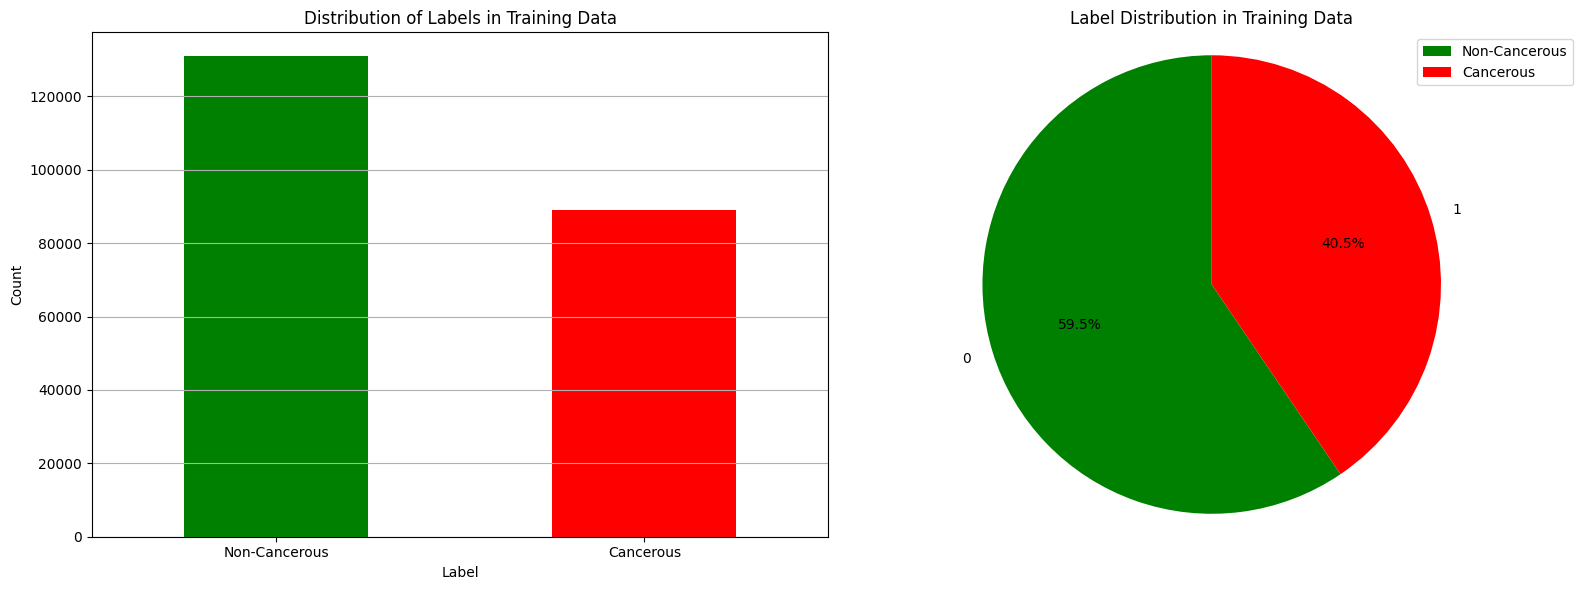

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of label counts on the left
eda_df['label'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=['green', 'red']
)
axes[0].set_title('Distribution of Labels in Training Data')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'], rotation=0)
axes[0].grid(axis='y')

# Pie chart of percentage distribution on the right
eda_df['label'].value_counts().plot(
    kind='pie',
    ax=axes[1],
    autopct='%1.1f%%',
    startangle=90,
    colors=['green', 'red']
)
axes[1].set_title('Label Distribution in Training Data')
axes[1].legend(['Non-Cancerous', 'Cancerous'], loc='upper right')
axes[1].set_ylabel('')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

In the training dataset, we have 59.5% of the images labeled as cancerous and 40.5% as non-cancerous. This is a significant imbalance, which we need to consider when training our model. Later, we will use weight balancing to address this issue during training.
Next, let's look at some of the images in the dataset to understand what they look like.

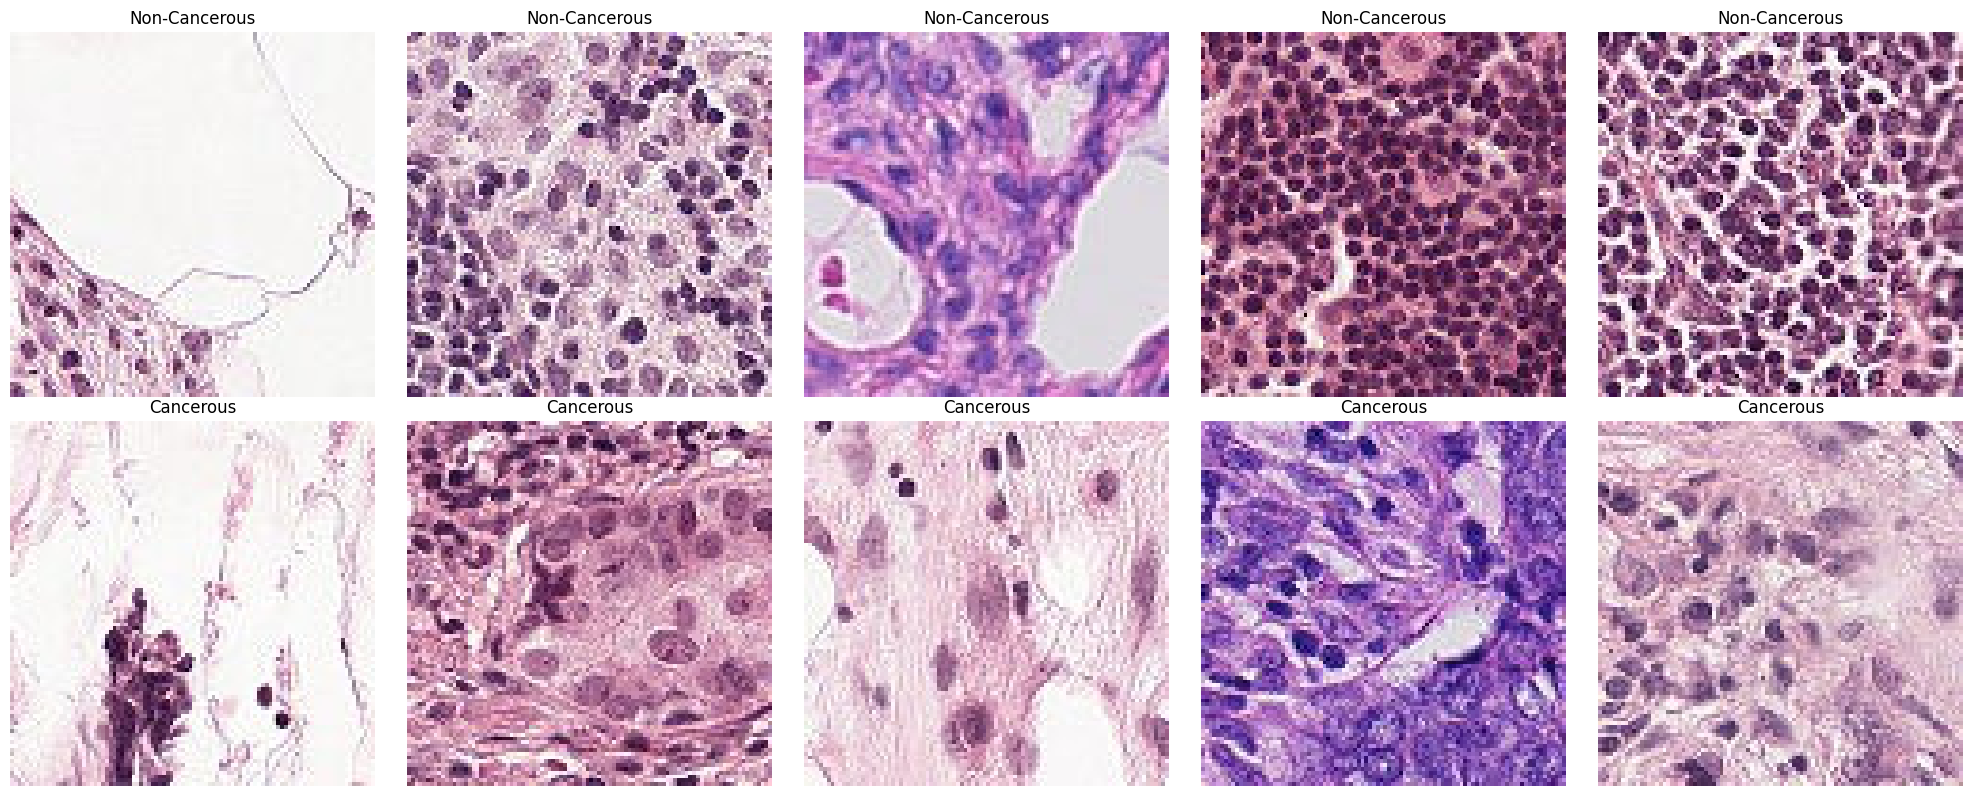

In [37]:
label_0_id = eda_df[eda_df['label'] == 0]['id'].values[:5]
label_1_id = eda_df[eda_df['label'] == 1]['id'].values[:5]

# image paths for the first 5 samples of each label
images_0 = [os.path.join(DATA_DIR, 'train', f'{id}.tif') for id in label_0_id]
images_1 = [os.path.join(DATA_DIR, 'train', f'{id}.tif') for id in label_1_id]

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, img_path in zip(axes[0], images_0):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title('Non-Cancerous')
    ax.axis('off')

for ax, img_path in zip(axes[1], images_1):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title('Cancerous')
    ax.axis('off')

plt.tight_layout()
plt.show()


Understanding the images needs significant domain knowledge, so in essence it's much more difficult for me to interpret these images and differentiate between cancerous and non-cancerous tissues! Therefore, I will focus on some image metadata like size, shape, and pixel values, which can help us understand the dataset better.

In [38]:
def imread_uint8(path):
    """Read image with plt.imread and coerce to uint8 [0,255]."""
    img = plt.imread(path)
    # plt.imread can return float [0,1] or uint8 [0,255] depending on file/type
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = (img * 255.0).clip(0, 255).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = img.astype(np.uint8)
    return img

def center_crop(img, size=32):
    h, w = img.shape[:2]
    cy, cx = h // 2, w // 2
    half = size // 2
    return img[cy - half:cy + half, cx - half:cx + half]

def to_gray(img):
    if img.ndim == 3 and img.shape[2] == 3:
        g = rgb2gray(img)  # returns float in [0,1]
        return g
    elif img.ndim == 2:
        # assume already grayscale uint8
        g = img.astype(np.float32) / 255.0
        return g
    else:
        # Unexpected channels
        x = img[..., 0] if img.ndim == 3 else img
        return x.astype(np.float32) / 255.0

def edge_density(img_gray_01):
    """Edge density via Sobel magnitude threshold (simple, parameter-free-ish)."""
    # sobel expects float [0,1]
    edges = sobel(img_gray_01)
    # adaptive-ish threshold: > median
    thr = np.median(edges)
    mask = edges > thr
    return mask.mean()

def image_features(img):
    """Compute a set of informative, cheap features."""
    h, w = img.shape[:2]
    # global stats
    min_v = int(img.min())
    max_v = int(img.max())
    mean_v = float(img.mean())
    std_v  = float(img.std())

    # per-channel (if RGB)
    if img.ndim == 3 and img.shape[2] == 3:
        ch_mean = img.reshape(-1, 3).mean(axis=0)
        ch_std  = img.reshape(-1, 3).std(axis=0)
        r_mean, g_mean, b_mean = [float(x) for x in ch_mean]
        r_std,  g_std,  b_std  = [float(x) for x in ch_std]
    else:
        r_mean = g_mean = b_mean = np.nan
        r_std  = g_std  = b_std  = np.nan

    # grayscale in [0,1] for entropy & edges
    g = to_gray(img)
    ent = float(shannon_entropy(g))  # entropy of grayscale image
    edens = float(edge_density(g))

    # center patch stats (dataset labels refer to center 32x32 region)
    c = center_crop(img, size=32)
    c_mean = float(c.mean())
    c_std  = float(c.std())
    c_min  = int(c.min())
    c_max  = int(c.max())

    return {
        "height": h,
        "width": w,
        "min": min_v,
        "max": max_v,
        "mean": mean_v,
        "std": std_v,
        "r_mean": r_mean, "g_mean": g_mean, "b_mean": b_mean,
        "r_std": r_std,   "g_std": g_std,   "b_std": b_std,
        "entropy": ent,
        "edge_density": edens,
        "center_mean": c_mean,
        "center_std": c_std,
        "center_min": c_min,
        "center_max": c_max,
    }

In [41]:
records = []
image_paths = [p for p in os.listdir(train_dir) if p.endswith(".tif")]
for fname in tqdm(image_paths, desc="Collecting image features"):
    fpath = os.path.join(train_dir, fname)
    if not os.path.isfile(fpath):
        continue
    img = imread_uint8(fpath)
    feats = image_features(img)
    feats["id"] = os.path.splitext(fname)[0]
    records.append(feats)



In [42]:
df_image_data = pd.DataFrame(records)
print("Feature table shape:", df_image_data.shape)
# display(df_image_data.head())

labels = pd.read_csv(labels_csv)  # columns: id, label (1=tumor, 0=normal)
df_image_data_with_labels = df_image_data.merge(labels, on="id", how="left")

# save the DataFrame to a CSV file to avoid recomputing
output_csv = os.path.join(DATA_DIR, "image_features.csv")
df_image_data_with_labels.to_csv(output_csv, index=False)
print(f"Image features saved to {output_csv}")

Feature table shape: (220025, 19)
Image features saved to ./data/image_features.csv


In [43]:
df_image_data_with_labels = pd.read_csv("./data/image_features.csv")

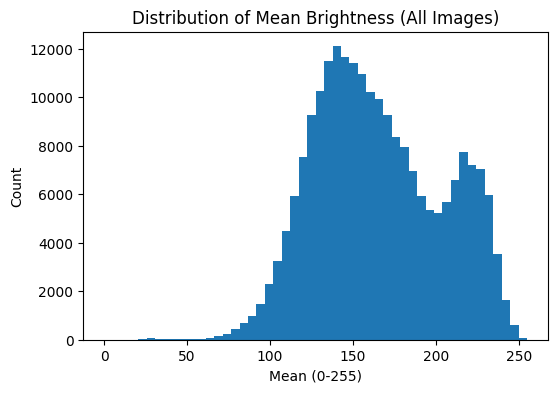

In [44]:
plt.figure(figsize=(6,4))
plt.hist(df_image_data_with_labels["mean"], bins=50)
plt.title("Distribution of Mean Brightness (All Images)")
plt.xlabel("Mean (0-255)")
plt.ylabel("Count")
plt.show()

This histogram shows the distribution of average brightness across all images in the dataset.
Most images have a mean brightness between about 120 and 180, which suggests they are moderately bright. There is also a smaller group of images with much higher brightness (around 220), which could be due to lighter staining or scanning differences.
Understanding brightness variation is important because strong differences can affect model training, and it may be necessary to normalize the images for consistent results.

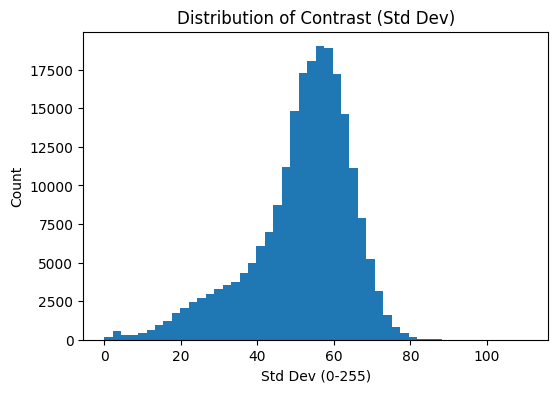

In [45]:
plt.figure(figsize=(6,4))
plt.hist(df_image_data_with_labels["std"], bins=50)
plt.title("Distribution of Contrast (Std Dev)")
plt.xlabel("Std Dev (0-255)")
plt.ylabel("Count")
plt.show()


This histogram shows the distribution of image contrast, measured by the standard deviation of pixel values.
Most images have a contrast between about 40 and 70, meaning there is a good range of light and dark areas in these patches. A few images have very low contrast (near 0–20), which might appear flat or washed out.
Checking contrast helps identify images that may be harder for the model to learn from and can guide preprocessing steps like contrast normalization.

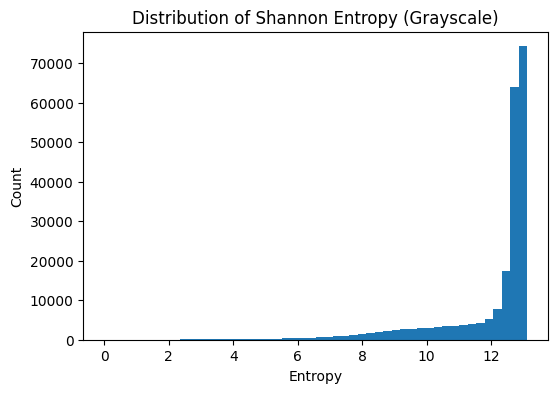

In [46]:

plt.figure(figsize=(6,4))
plt.hist(df_image_data_with_labels["entropy"], bins=50)
plt.title("Distribution of Shannon Entropy (Grayscale)")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.show()


This histogram shows the distribution of Shannon entropy for the images after converting them to grayscale.
Entropy measures the amount of information or complexity in an image. Most images have very high entropy values, close to 13, meaning they contain a lot of detail and variation in pixel intensity. A small number of images have much lower entropy, which could indicate smooth or uniform areas with little structure.
This helps identify simple or low-information images that might be less useful for the model or could require special handling.

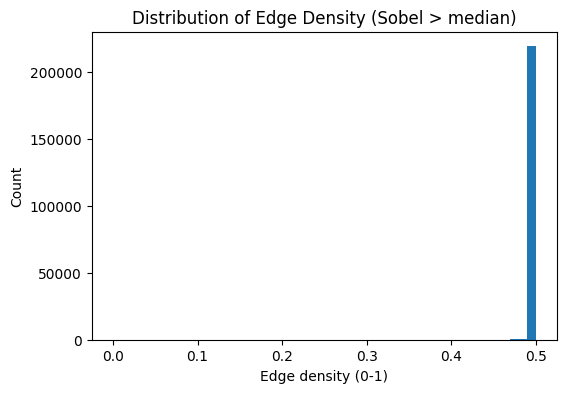

In [47]:
plt.figure(figsize=(6,4))
plt.hist(df_image_data_with_labels["edge_density"], bins=50)
plt.title("Distribution of Edge Density (Sobel > median)")
plt.xlabel("Edge density (0-1)")
plt.ylabel("Count")
plt.show()

This histogram shows the distribution of edge density in the images, calculated using the Sobel filter and a median threshold.
Almost all images have an edge density close to 0.5, meaning about half of their pixels are detected as edges under this method. This suggests that the threshold used is not separating images with different levels of structure very well.
The lack of spread in values indicates that edge density, as currently calculated, might not be a useful feature without adjusting the threshold or using a more sensitive method.

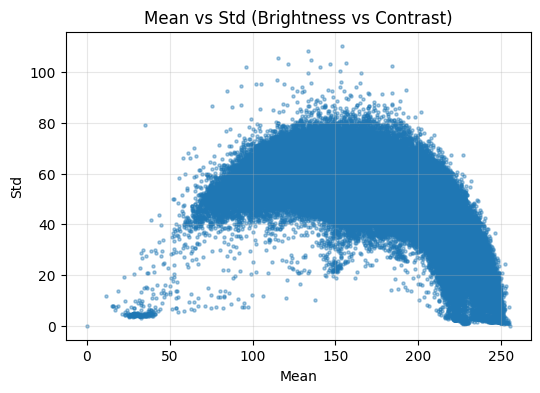

In [48]:
plt.figure(figsize=(6,4))
plt.scatter(df_image_data_with_labels["mean"], df_image_data_with_labels["std"], s=5, alpha=0.4)
plt.title("Mean vs Std (Brightness vs Contrast)")
plt.xlabel("Mean")
plt.ylabel("Std")
plt.grid(True, alpha=0.3)
plt.show()

This scatter plot compares the mean brightness of each image with its contrast (standard deviation).
Most images fall within a curved band: very dark or very bright images tend to have lower contrast, while medium-brightness images often have higher contrast. This pattern is expected because extremely light or dark patches usually have less variation in pixel values.
The plot helps identify outliers, such as very bright images with unusually high contrast or very dark images with almost no contrast, which could require special preprocessing.

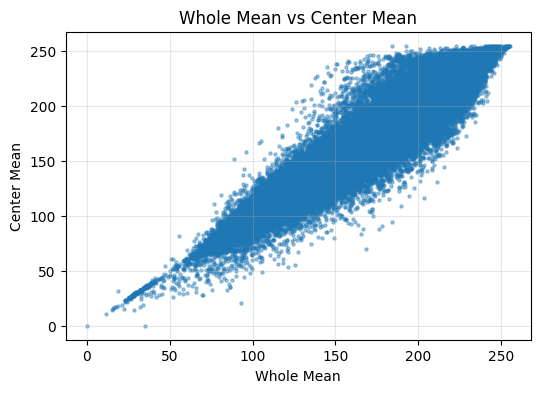

In [49]:
plt.figure(figsize=(6,4))
plt.scatter(df_image_data_with_labels["mean"], df_image_data_with_labels["center_mean"], s=5, alpha=0.4)
plt.title("Whole Mean vs Center Mean")
plt.xlabel("Whole Mean")
plt.ylabel("Center Mean")
plt.grid(True, alpha=0.3)
plt.show()

This scatter plot compares the average brightness of the whole image with the average brightness of its central $32 \times 32$ region.
There is a strong positive correlation, meaning that brighter images usually have brighter centers and darker images have darker centers. However, some points fall away from the diagonal line, showing cases where the center is lighter or darker than the rest of the image.
This difference is important because the cancer labels in this dataset are based on the center region, so variations between the center and whole image may provide useful information for the model.

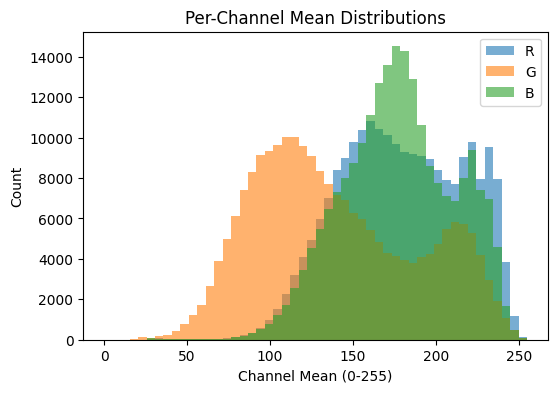

In [50]:
rgb_means = df_image_data_with_labels[["r_mean","g_mean","b_mean"]].dropna()
plt.figure(figsize=(6,4))
plt.hist(rgb_means["r_mean"], bins=50, alpha=0.6, label="R")
plt.hist(rgb_means["g_mean"], bins=50, alpha=0.6, label="G")
plt.hist(rgb_means["b_mean"], bins=50, alpha=0.6, label="B")
plt.title("Per-Channel Mean Distributions")
plt.xlabel("Channel Mean (0-255)")
plt.ylabel("Count")
plt.legend()
plt.show()

This plot shows the distribution of average intensity for each color channel (Red, Green, and Blue).
The green channel has noticeably lower mean values compared to red and blue, which both tend to be brighter. This difference is likely due to the staining process used in histopathology images, which affects how colors appear.
Knowing the color balance is important because it may influence how the model interprets features, and it can help decide whether to normalize channels separately to reduce color bias.

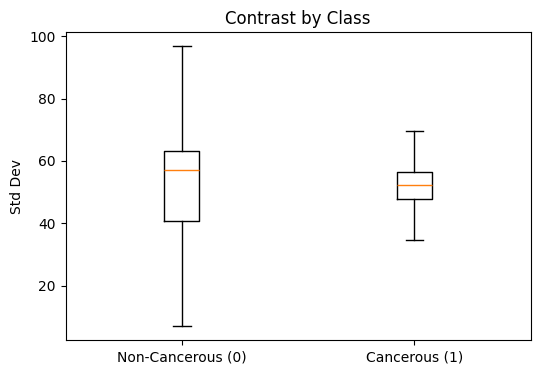

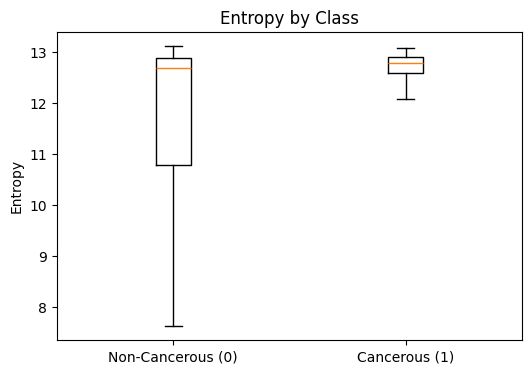

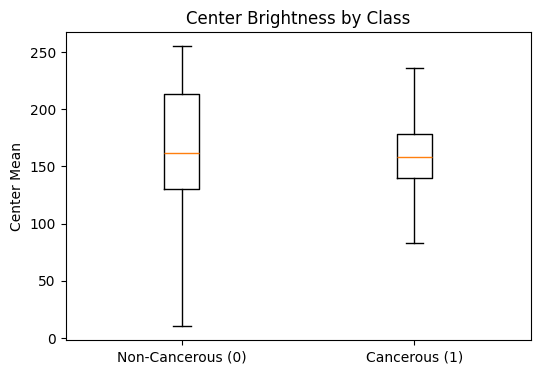

In [51]:
if "label" in df_image_data_with_labels.columns and df_image_data_with_labels["label"].notna().any():
    # Boxplots: class-wise contrast, entropy, center_mean
    def boxplot_col(col, title, ylabel):
        plt.figure(figsize=(6,4))
        data0 = df_image_data_with_labels.loc[df_image_data_with_labels["label"] == 0, col].dropna()
        data1 = df_image_data_with_labels.loc[df_image_data_with_labels["label"] == 1, col].dropna()
        plt.boxplot([data0, data1], tick_labels=["Non-Cancerous (0)", "Cancerous (1)"], showfliers=False)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.show()

    boxplot_col("std", "Contrast by Class", "Std Dev")
    boxplot_col("entropy", "Entropy by Class", "Entropy")
    boxplot_col("center_mean", "Center Brightness by Class", "Center Mean")

Contrast by Class:

This boxplot compares image contrast between non-cancerous and cancerous tiles. Non-cancerous images show a wider range of contrast values, from very low to high, while cancerous images are more concentrated around medium contrast levels. This suggests that contrast alone is not a perfect separator, but extreme low or high values are more common in non-cancerous samples.

Entropy by Class:

Here we compare image entropy, which measures texture complexity. Cancerous images tend to have slightly more consistent entropy values, while non-cancerous images show a larger spread, including some low-entropy cases. This indicates that texture differences might help the model but are not strongly distinct between classes.

Center Brightness by Class:

This plot compares the brightness of the central 32×32 region of each image. Both classes have a similar range, but non-cancerous samples show more extreme values—some very bright and some very dark centers—while cancerous samples are more tightly grouped around medium brightness. Since the label is based on the center, this feature may help distinguish classes in certain cases.

In [52]:
def show_thumbnails(df_sub, title, n, cols=4, show_titles=True):
    n = min(n, len(df_sub))
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*5, rows*7))
    for i, row in enumerate(df_sub.head(n).itertuples(index=False), 1):
        img_path = os.path.join(train_dir, f"{row.id}.tif")
        img = imread_uint8(img_path)
        plt.subplot(rows, cols, i)
        if show_titles:
            plt.title(row.id)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

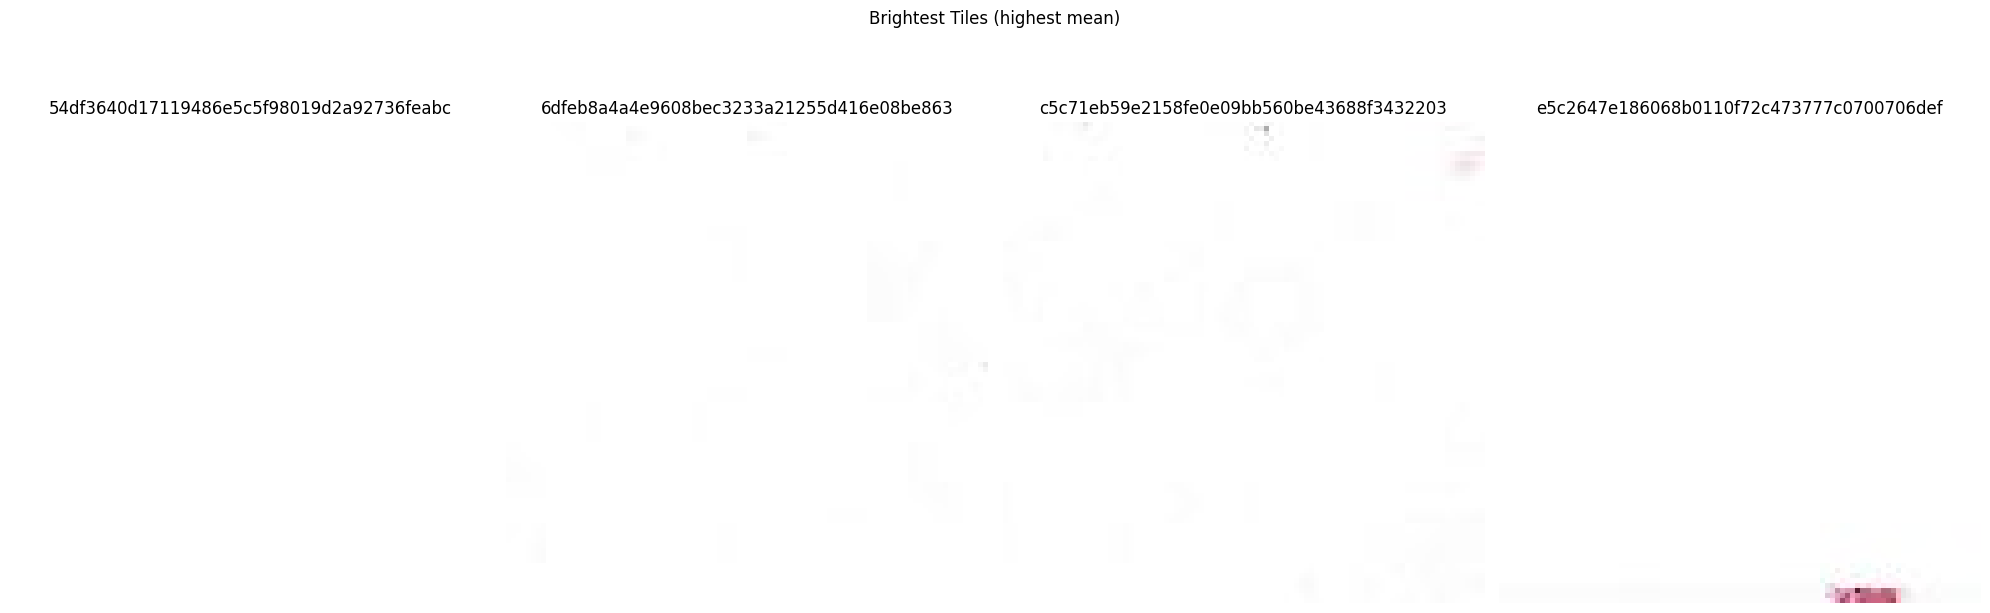

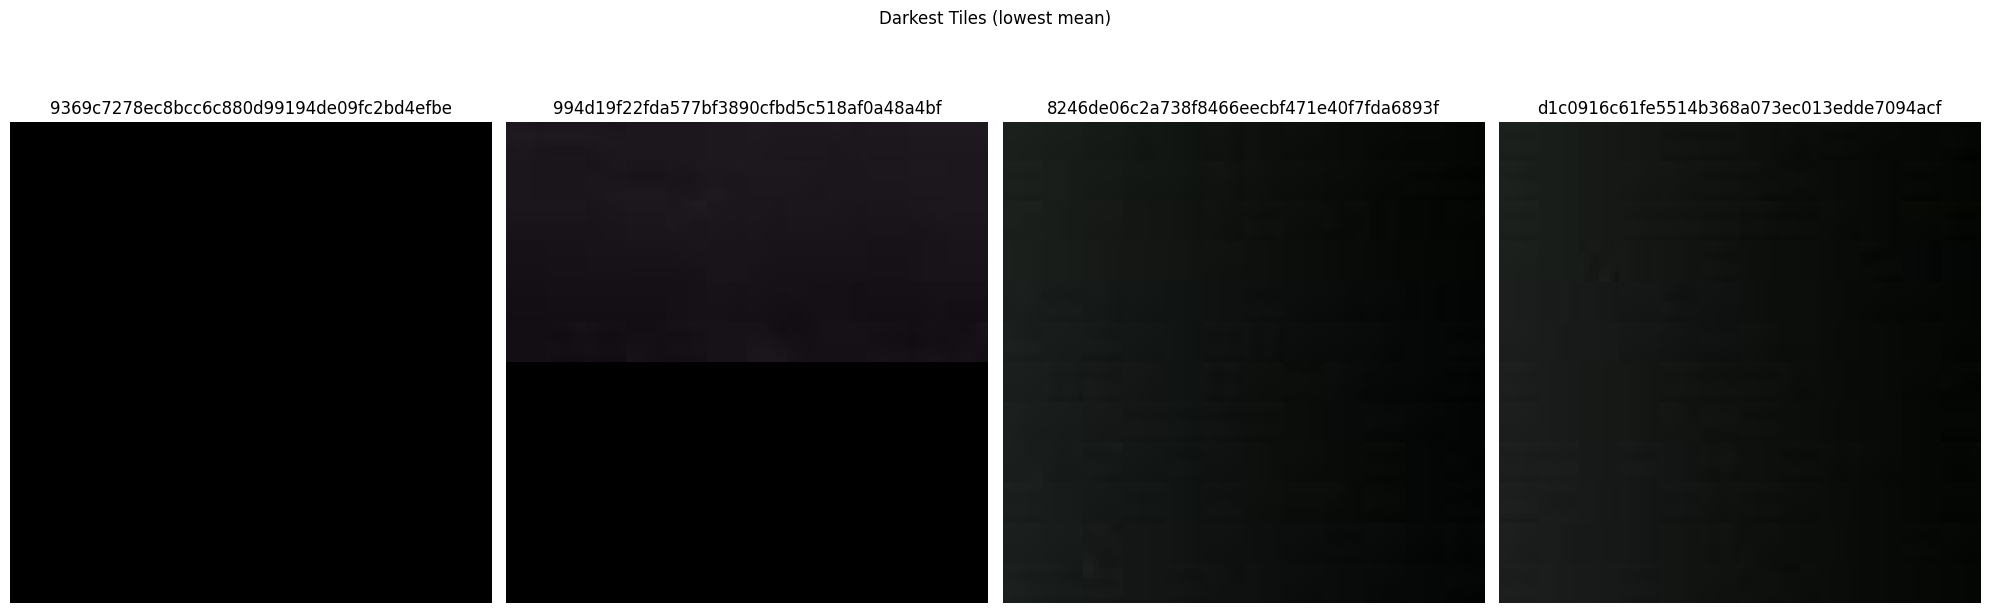

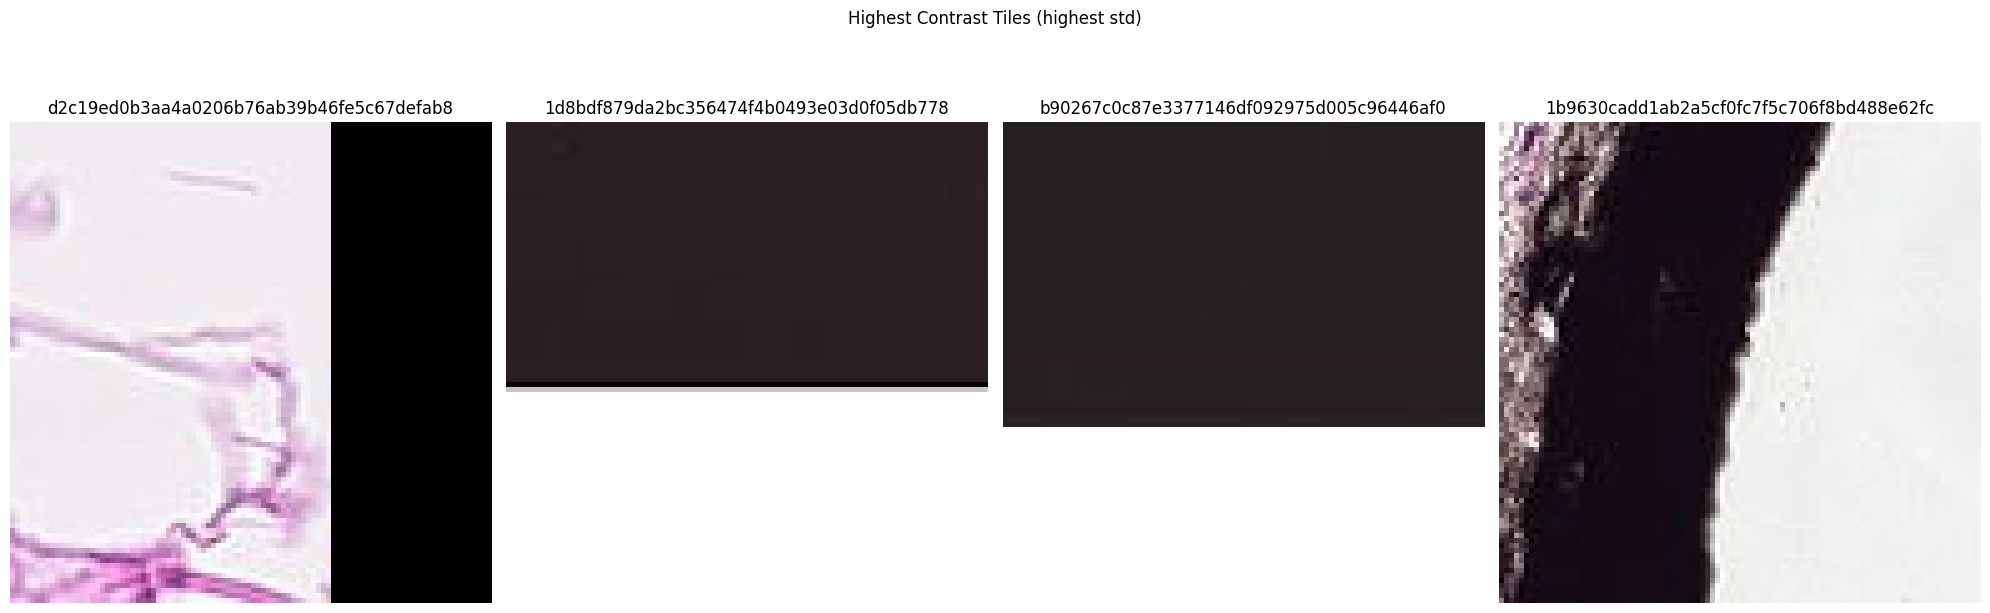

In [53]:
df_sorted_bright = df_image_data_with_labels.sort_values("mean", ascending=False)
df_sorted_dark   = df_image_data_with_labels.sort_values("mean", ascending=True)
df_sorted_contrast = df_image_data_with_labels.sort_values("std", ascending=False)

VISUALIZATION_SAMPLE_SIZE = 4

show_thumbnails(df_sorted_bright, "Brightest Tiles (highest mean)", VISUALIZATION_SAMPLE_SIZE)
show_thumbnails(df_sorted_dark,   "Darkest Tiles (lowest mean)", VISUALIZATION_SAMPLE_SIZE)
show_thumbnails(df_sorted_contrast, "Highest Contrast Tiles (highest std)", VISUALIZATION_SAMPLE_SIZE)


Brightest Tiles (highest mean):

These tiles are almost completely white with very little visible tissue structure. This may be due to empty regions, light staining, or scanning artifacts. Such bright tiles may carry little useful information for the model and could be candidates for removal.

Darkest Tiles (lowest mean):

These images are very dark, in some cases nearly black. This suggests they may contain background, heavily stained regions, or image capture errors. Extremely dark tiles may also lack enough information for effective classification.

Highest Contrast Tiles (highest std):

These tiles show strong differences between light and dark areas, often due to the presence of dense tissue against a bright background. While high contrast can highlight important structures, it may also indicate artifacts such as borders or scanning edges that the model should not learn as cancer-related features.



## Model Training

I evaluate two different modeling strategies for histopathological image classification:

1. Custom Convolutional Neural Network (SimpleCNN): A small CNN designed and trained from scratch on the dataset. This serves as a baseline model to understand how a relatively shallow architecture can learn discriminative features directly from the 96×96 image patches.
2. Transfer Learning with ResNet50: A deep residual network pretrained on ImageNet, with its final classification layer replaced by a binary output layer. In this setup, most of the network’s parameters are frozen, and only the last block (plus the classifier head) is fine-tuned. This approach leverages prior knowledge from large-scale natural image data and typically improves performance in medical imaging tasks with limited labeled data.

In [5]:
labels_df = pd.read_csv(LABEL_FILE_PATH)
labels_df.set_index("id", inplace=True)

In [6]:
data_transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
ds = ImageDataset(data_dir=DATA_DIR, transform=data_transformer, label_df=labels_df, data_type="train")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


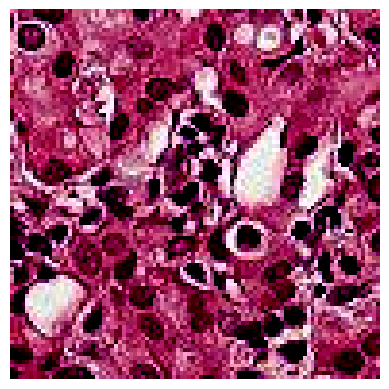

label: 1


In [7]:
# get a sample from the dataset
sample_image, sample_label = ds[0]
# show image
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(f"label: {sample_label}")

### Train–Validation Split

To evaluate model performance fairly, the dataset is split into training (80%) and validation (20%) subsets.  
This is done using PyTorch’s `random_split`, with a fixed random generator (`g`) for reproducibility.  
- Training set: used to fit the model parameters.  
- Validation set: held-out data for monitoring generalization and guiding model selection (e.g., early stopping, best checkpoint).  

In [8]:
trainset, valset = random_split(
    ds, [int(0.8 * len(ds)), len(ds) - int(0.8 * len(ds))], generator=g
)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=NUM_WORKERS, persistent_workers=True)
testloader  = torch.utils.data.DataLoader(valset,   batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, persistent_workers=True)

In [ ]:
def evaluate(model, loader, criterion, device):
    """
    Evaluate a binary classification model on a given dataset loader.

    This function runs the model in evaluation mode without gradient computation,
    computes the average loss, and calculates performance metrics including
    accuracy and ROC–AUC score.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader providing (image, label) batches.
        criterion (torch.nn.Module): Loss function, typically `nn.BCEWithLogitsLoss`.
        device (torch.device): Device on which computation is performed (e.g., "cpu", "cuda", "mps").

    Returns:
        tuple:
            - float: Mean loss over all batches.
            - float: Accuracy score using a threshold of 0.5 on predicted probabilities.
            - float: ROC–AUC score, measuring discrimination ability between classes.
    """
    model.eval()
    losses, probs_all, y_all = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)     # (B,1)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            probs = torch.sigmoid(logits)             # (B,1)
            probs_all.append(probs.cpu())
            y_all.append(y.cpu())
    probs_all = torch.cat(probs_all).squeeze(1).numpy()
    y_all = torch.cat(y_all).squeeze(1).numpy()
    auc = roc_auc_score(y_all, probs_all)
    acc = accuracy_score(y_all, (probs_all >= 0.5).astype(int))



    return sum(losses)/len(losses), acc, auc

### SimpleCNN Architecture

The SimpleCNN architecture is intentionally straightforward and inspired by classical CNN designs:

- Convolution + Pooling Stacks  
  - Conv1 (3→32 filters, 3×3 kernel) + MaxPool(2×2)  
  - Conv2 (32→64 filters, 3×3) + MaxPool(2×2)  
  - Conv3 (64→128 filters, 3×3) + MaxPool(2×2)  
  These progressively extract low- to mid-level features such as edges, textures, and small patterns, while reducing spatial resolution.

- Fully Connected Layers  
  - A dense layer of 128 neurons with ReLU activation.  
  - A Dropout layer (p=0.5) to reduce overfitting.  
  - A final 1-neuron output layer producing a logit for binary classification.

- Activation & Loss  
  ReLU is used after each convolution and the first dense layer. For training, I use `BCEWithLogitsLoss`, which internally applies a sigmoid to the logits and computes binary cross-entropy loss in a numerically stable way.

#### Why This Design?

- Simplicity and Interpretability: A compact CNN allows clear understanding of how convolutional filters and pooling contribute to feature extraction.  
- Appropriate for Input Size: Since images are relatively small (96×96), a shallow network with three convolutional blocks is sufficient to capture spatial hierarchies without excessive depth.  
- Regularization: Dropout in the fully connected layer helps prevent overfitting, which is a risk given the large dataset but relatively small feature diversity.  
- Baseline for Comparison: This model provides a benchmark to compare against the more powerful ResNet50 transfer learning setup. Any performance gap highlights the benefits of leveraging pretrained deep architectures.


In [11]:
class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network for binary classification of histopathological images.
    The architecture inspired by common CNN structures includes three convolutional layers followed by max pooling,
    a fully connected layer, dropout for regularization, and a final output layer.

    The input images are expected to have three channels (RGB) and a shape of (96, 96, 3) as it's the default shape in the dataset.
    The output is a single logit value for binary classification.
    The model uses ReLU activation functions after each convolutional layer and before the final output layer.
    Dropout is applied after the first fully connected layer to prevent overfitting.
    The model is designed to be trained with a binary cross-entropy loss function, specifically using
    `nn.BCEWithLogitsLoss`, which combines a sigmoid layer and the binary cross-entropy loss in a single class.
    This is more numerically stable than using a plain Sigmoid followed by a BCELoss.

    Args:
        dropout_p (float): Probability of an element to be zeroed in the dropout layer.
                           Default is 0.5, which means 50% of the elements will be set to zero during training.
    Returns:
        A PyTorch model that can be trained on histopathological images for binary classification.
    The model's forward method takes an input tensor of shape (B, 3, 96, 96) where B is the batch size,
    and returns an output tensor of shape (B, 1) containing the logit values for each image in the batch.
    """
    def __init__(self, dropout_p: float = 0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) # input channels 3 (RGB), output channels 32 (feature maps), output shape is (B, 32, 94, 94) ==> (96-3)/1 + 1 = 94
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims ==> (94-2)/2 + 1 = 47, output shape is (B, 32, 47, 47)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # in_channels=32 from previous layer, out_channels=64 (feature maps), output shape is (B, 64, 45, 45) ==> (47-3)/1 + 1 = 45
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims again ==> (45-2)/2 + 1 = 22, output shape is (B, 64, 22, 22)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # in_channels=64 from previous layer, out_channels=128 (feature maps), output shape is (B, 128, 20, 20) ==> (22-3)/1 + 1 = 20
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims again ==> (20 - 2)/2 + 1 = 10, output shape is (B, 128, 10, 10)

        # the shape after the last pooling layer is (B, 128, 10, 10)
        self.fc1 = nn.Linear(in_features=128 * 10 * 10, out_features=128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(in_features=128, out_features=1)  # binary logit output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = torch.flatten(x, 1)      # flatten all dims except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)              # no sigmoid here (use BCEWithLogitsLoss)
        return x


### Handling Class Imbalance with `pos_weight`

The function `compute_pos_weight` calculates the positive class weight for `BCEWithLogitsLoss`. In many medical imaging datasets, such as cancer detection, negative samples (no cancer) are much more common than positive ones (cancer). If we train without adjustment, the model could become biased toward predicting the majority class. By computing the ratio of negative to positive samples (`neg / pos`), this function provides a `pos_weight` that tells the loss function to penalize mistakes on positive cases more strongly. This helps the model pay balanced attention to both classes, improving its ability to detect cancerous images.  

In [ ]:
def compute_pos_weight(dataset_or_subset, device):
    if isinstance(dataset_or_subset, Subset):
        base_ds = dataset_or_subset.dataset    # the underlying ImageDataset
        idxs = dataset_or_subset.indices
        labels = [base_ds.items[i][1] for i in idxs]
    else:
        labels = [lbl for _, lbl in dataset_or_subset.items]

    labels_t = torch.as_tensor(labels, dtype=torch.long)
    counts = torch.bincount(labels_t, minlength=2)  # [neg, pos]
    neg, pos = counts[0].item(), counts[1].item()
    pos = max(pos, 1)
    return torch.tensor([neg / pos], device=device, dtype=torch.float32)



In [ ]:
simple_cnn_model = SimpleCNN().to(device)
pos_weight = compute_pos_weight(trainset, device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # pos_weight to handle class imbalance
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

In [ ]:
def train_simplecnn_mps(
    model: nn.Module,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    *,
    epochs: int = 10,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    early_stopping_patience: int = 3,
    grad_clip: Optional[float] = None,
    best_path: str = best_cnn_path,  # Path to save the best model checkpoint
):
    """
    Train a SimpleCNN model on Apple MPS or other devices.

    This function trains a binary classification CNN with mixed precision
    on MPS (if available). It monitors validation AUC to select the best
    checkpoint, applies early stopping, and optionally clips gradients.

    Args:
        - model (nn.Module): The model to train.
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        - criterion (nn.Module): Loss function, e.g., `nn.BCEWithLogitsLoss`.
        - optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        - device (torch.device): Target device ("mps", "cuda", or "cpu").
        - epochs (int, optional): Maximum number of training epochs. Default is 10.
        - scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate
            scheduler. If `ReduceLROnPlateau`, it steps on validation AUC.
        - early_stopping_patience (int, optional): Number of epochs without AUC
            improvement before early stopping. Default is 3.
        - grad_clip (float, optional): Maximum norm for gradient clipping. Default is None.
        - best_path (str, optional): Path to save the best model checkpoint. Default is `best_cnn_path`.

    Returns:
        tuple:
            - nn.Module: Model restored to the best checkpoint (highest validation AUC).
            - list[dict]: Training history, with metrics per epoch including:
                * "epoch": epoch number
                * "train_loss": average training loss
                * "val_loss": validation loss
                * "val_acc": validation accuracy
                * "val_auc": validation AUC
                * "lrs": learning rates per param group
                * "time_s": epoch duration in seconds
    """
    use_amp = device.type == "mps"

    best_auc = -math.inf
    best_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    history = []

    for epoch in range(1, epochs + 1):
        t0 = time.perf_counter()
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=False)
            labels = labels.to(device, non_blocking=False).float().unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with autocast("mps"):
                    logits = model(imgs)
                    loss = criterion(logits, labels)
            else:
                logits = model(imgs)
                loss = criterion(logits, labels)

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item()

        # --- Validation ---
        val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)

        # --- Scheduler ---
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_auc)
            else:
                scheduler.step()

        # --- Keep best by AUC ---
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(
                {
                    "model_state": best_state,
                    "optimizer_state": optimizer.state_dict(),
                    "scheduler_state": (
                        scheduler.state_dict() if scheduler is not None else None
                    ),
                    "auc": best_auc,
                    "epoch": epoch,
                },
                best_path,
            )
            print(f"[SimpleCNN-MPS] Saved best checkpoint to {best_path}")
        else:
            epochs_no_improve += 1

        dt = time.perf_counter() - t0
        train_loss = running_loss / max(1, len(train_loader))

        # LR log (handles single/multi param groups)
        lrs = (
            [pg.get("lr", float("nan")) for pg in optimizer.param_groups]
            if hasattr(optimizer, "param_groups")
            else []
        )
        lr_str = ",".join(f"{lr:.2e}" for lr in lrs) if lrs else "n/a"

        print(
            f"[SimpleCNN-MPS] epoch {epoch:02d} | "
            f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"val_acc {val_acc:.4f} | val_auc {val_auc:.4f} | "
            f"lr {lr_str} | {dt:.1f}s"
        )

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_auc": val_auc,
                "lrs": lrs,
                "time_s": dt,
            }
        )

        # --- Early stopping ---
        if (
            early_stopping_patience is not None
            and epochs_no_improve >= early_stopping_patience
        ):
            print(
                f"[SimpleCNN-MPS] Early stopping after {epoch} epochs (no AUC improvement)."
            )
            break

    # Load best checkpoint
    model.load_state_dict(best_state)
    return model, history

In [14]:
simple_cnn_model, hist = train_simplecnn_mps(
    simple_cnn_model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    device,
    epochs=15,
    scheduler=scheduler,
    early_stopping_patience=4,
    grad_clip=1.0, 
)

[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 01 | train_loss 0.6305 | val_loss 0.6657 | val_acc 0.8630 | val_auc 0.9322 | lr 1.00e-03 | 253.4s
[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 02 | train_loss 0.5575 | val_loss 0.4964 | val_acc 0.8704 | val_auc 0.9414 | lr 1.00e-03 | 246.6s
[SimpleCNN-MPS] epoch 03 | train_loss 0.5412 | val_loss 0.6822 | val_acc 0.8619 | val_auc 0.9338 | lr 1.00e-03 | 247.5s
[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 04 | train_loss 0.5344 | val_loss 0.4392 | val_acc 0.8871 | val_auc 0.9511 | lr 1.00e-03 | 248.3s
[SimpleCNN-MPS] epoch 05 | train_loss 0.5285 | val_loss 0.5003 | val_acc 0.8787 | val_auc 0.9483 | lr 1.00e-03 | 240.6s
[SimpleCNN-MPS] epoch 06 | train_loss 0.5205 | val_loss 0.7154 | val_acc 0.8697 | val_auc 0.9267 | lr 1.00e-03 | 240.3s
[SimpleCNN-MPS] epoch 07 | train_loss 0.5212 |

In [15]:
val_loss, val_acc, val_auc = evaluate(simple_cnn_model, testloader, criterion, device)
print(f"[SimpleCNN-MPS BEST] val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  val_auc: {val_auc:.4f}")

[SimpleCNN-MPS BEST] val_loss: 0.4659  val_acc: 0.9024  val_auc: 0.9606


In [ ]:
@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
    """
    Collect predicted probabilities and true labels from the model on the given data loader.
    Args:
        model (torch.nn.Module): The trained model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader providing (image, label) batches.
        device (torch.device): Device on which computation is performed (e.g., "cpu", "cuda", "mps").
    Returns:
        tuple:
            - np.ndarray: Array of predicted probabilities for the positive class.
            - np.ndarray: Array of true binary labels.
    """
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float().unsqueeze(1)
        logits = model(x)
        probs = torch.sigmoid(logits)
        probs_all.append(probs.cpu())
        y_all.append(y.cpu())
    probs_all = torch.cat(probs_all).squeeze(1).numpy()
    y_all = torch.cat(y_all).squeeze(1).numpy()
    return probs_all, y_all


Loaded best SimpleCNN checkpoint (epoch=14, auc=0.9606)


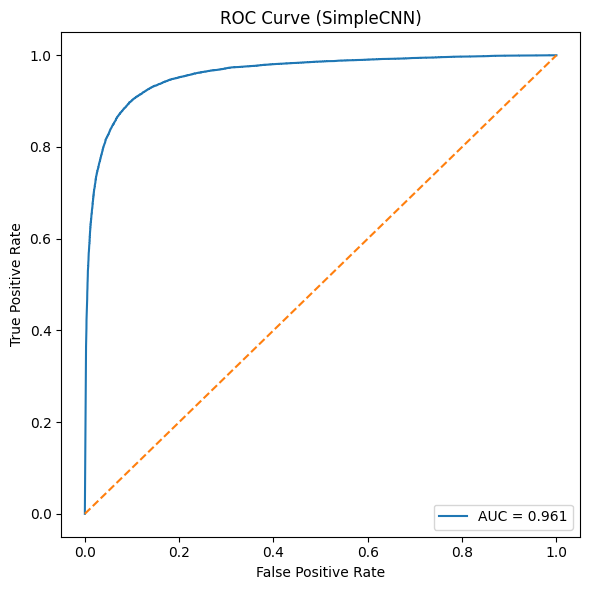

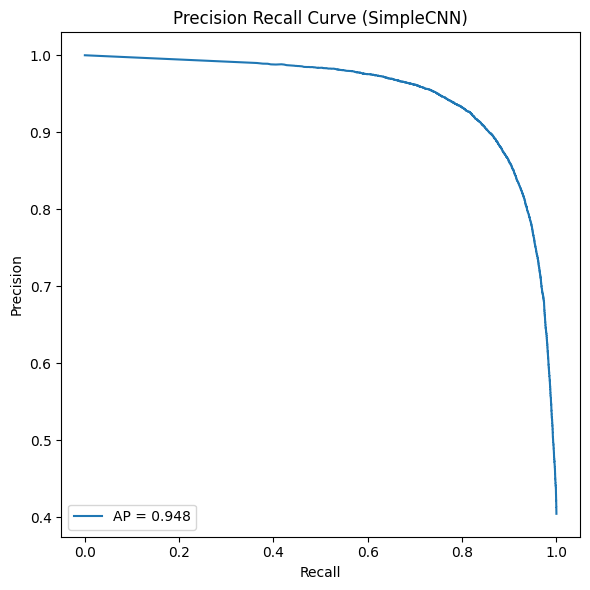

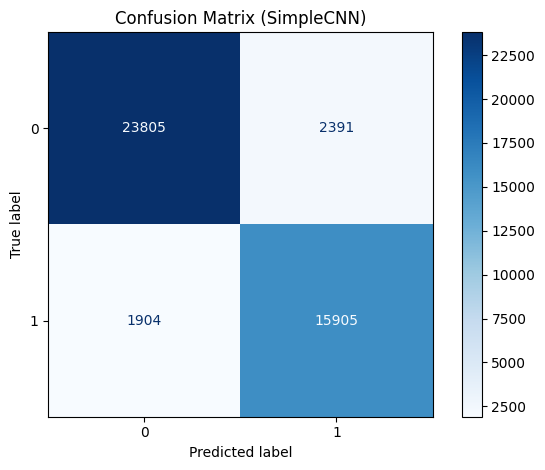

In [32]:
if os.path.exists(best_cnn_path):
    ckpt = torch.load(best_cnn_path, map_location=device)
    simple_cnn_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best SimpleCNN checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")


probs_all, y_all = collect_probs_and_labels(simple_cnn_model, testloader, device)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = roc_auc_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SimpleCNN)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Precision–Recall Curve ---
prec, rec, _ = precision_recall_curve(y_all, probs_all)
ap = average_precision_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve (SimpleCNN)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
y_pred = (probs_all >= 0.5).astype(int)

cm = confusion_matrix(y_all, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix (SimpleCNN)")
plt.tight_layout()
plt.show()


### Evaluation of SimpleCNN

The SimpleCNN model achieved a validation loss of **0.466**, with an accuracy of **90.2%** and an AUC of **0.961**. The ROC curve shows that the model has very strong discriminative ability, as the curve is close to the top-left corner. The Precision–Recall curve also demonstrates high performance with an average precision of **0.948**, which is important given the class imbalance in the dataset. The confusion matrix indicates that the model correctly classifies most positive and negative cases, though there are still some false positives (2,391) and false negatives (1,904). Overall, the results show that even a relatively simple CNN can capture important patterns in the histopathology images and perform well on this binary classification task. In the next section, I will compare this baseline with a deeper transfer learning approach using ResNet50 to see if leveraging pretrained features can further improve performance.

## Transfer Learning with ResNet50

To build on the baseline, I apply transfer learning with a pretrained ResNet50. The idea is to reuse generic visual features learned from ImageNet (edges, textures, shapes) and adapt only the final layers to this binary task. 

I normalize inputs with ImageNet mean/std and use light augmentations for training (resize to 256 → random resized crop to 224, horizontal flip) while keeping validation deterministic (resize + center crop). I construct train/val datasets with these transforms and reuse the exact same split indices as SimpleCNN for a fair comparison. 

The ResNet50 head is replaced by a single-logit layer, and I freeze all layers except `layer4` and the new `fc` (fine‑tune‑last‑block strategy). I optimize with AdamW using differential learning rates (a gentle LR for the backbone, higher LR for the head) and BCEWithLogitsLoss with `pos_weight` to counter class imbalance (same as SimpleCNN). A `ReduceLROnPlateau` scheduler steps on validation `AUC`, and the training loop saves the best checkpoint by `AUC`. 

In [17]:
# ImageNet normalization
IMAGENET_MEAN = ResNet50_Weights.IMAGENET1K_V2.transforms().mean
IMAGENET_STD  = ResNet50_Weights.IMAGENET1K_V2.transforms().std

resnet_train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

resnet_val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [ ]:
# Base datasets with ResNet transforms
ds_train_resnet = ImageDataset(DATA_DIR, transform=resnet_train_tf, label_df=labels_df, data_type="train")
ds_val_resnet   = ImageDataset(DATA_DIR, transform=resnet_val_tf,   label_df=labels_df, data_type="train")

# Reuse the exact same split indices
trainset_resnet = torch.utils.data.Subset(ds_train_resnet, trainset.indices)
valset_resnet   = torch.utils.data.Subset(ds_val_resnet,   valset.indices)

pin_mem = (device.type == "cuda") # pin_memory only for CUDA

trainloader_resnet = torch.utils.data.DataLoader(
    trainset_resnet, batch_size=16, shuffle=True, num_workers=2, pin_memory=pin_mem
)
valloader_resnet = torch.utils.data.DataLoader(
    valset_resnet, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin_mem
)

In [19]:
pos_weight = compute_pos_weight(trainset_resnet, device)
criterion_resnet = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
def build_resnet50_model(fine_tune_last_block: bool = True):
    """
    Build a ResNet50 model for binary classification with optional fine-tuning.

    This function loads a ResNet50 pretrained on ImageNet (using the
    `ResNet50_Weights.IMAGENET1K_V2` weights), replaces the final fully connected
    layer with a single-logit output for binary classification, and controls which
    layers are trainable.

    Args:
        fine_tune_last_block (bool, optional): 
            - If True, unfreezes the parameters in the last residual block (`layer4`)
              and the final fully connected layer for fine-tuning.
            - If False, only the final fully connected layer is trainable 
              (all other layers remain frozen).
            Default is True.

    Returns:
        torch.nn.Module: A ResNet50 model adapted for binary classification, 
        moved to the global `device`.
    """
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = resnet50(weights=weights)

    # Replace classifier head for binary logit output
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)

    # Freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if fine_tune_last_block:
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True
    else:
        # Head-only: train only the last fc layer
        for p in model.fc.parameters():
            p.requires_grad = True

    return model.to(device)


resnet_model = build_resnet50_model(fine_tune_last_block=True)

# Parameter groups: lower LR for backbone, higher for head
backbone_params = [
    p
    for n, p in resnet_model.named_parameters()
    if p.requires_grad and not n.startswith("fc.")
]
head_params = [
    p
    for n, p in resnet_model.named_parameters()
    if n.startswith("fc.") and p.requires_grad
]

optimizer_resnet = optim.AdamW(
    [
        {"params": backbone_params, "lr": 3e-5},  # gentle fine-tuning
        {"params": head_params, "lr": 1e-3},  # faster on the new head
    ],
    weight_decay=1e-4,
)

scheduler_resnet = ReduceLROnPlateau(
    optimizer_resnet, mode="max", factor=0.5, patience=2
)

4.9%

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/mark/.xdg_cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100.0%


In [ ]:
def train_resnet_mps(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    """
    Train a ResNet50 model with mixed precision support on Apple MPS.

    This function trains a binary classification ResNet50 model using the given
    optimizer, loss function, and scheduler. Training runs for the specified
    number of epochs, and the model is evaluated after each epoch on the validation
    set. The checkpoint with the best validation AUC is saved to disk, and the
    model is restored to this best state before returning.

    Mixed precision (`autocast("mps")`) is automatically enabled when running
    on Apple Metal Performance Shaders (MPS).

    Args:
        model (torch.nn.Module): The ResNet50 model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): Loss function, e.g., `nn.BCEWithLogitsLoss`.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler,
            stepped each epoch based on validation AUC.
        device (torch.device): Device on which training/evaluation will run ("mps", "cuda", or "cpu").
        epochs (int, optional): Maximum number of epochs. Default is 10.

    Returns:
        torch.nn.Module: The trained ResNet50 model restored to the best checkpoint 
        (highest validation AUC).
    """    
    use_amp = (device.type == "mps")
    best_auc, best_state = -1.0, copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs+1):
        t0 = time.perf_counter()
        model.train()
        running = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device); labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad(set_to_none=True)
            if use_amp:
                with autocast("mps"):
                    logits = model(imgs); loss = criterion(logits, labels)
            else:
                logits = model(imgs); loss = criterion(logits, labels)
            loss.backward(); optimizer.step()
            running += loss.item()

        val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            torch.save({"model": best_state, "auc": best_auc, "epoch": epoch}, best_resnet_path)
            print(f"[ResNet50] Saved best checkpoint to {best_resnet_path}")

        dt = time.perf_counter() - t0
        print(f"[ResNet50] epoch {epoch:02d} | train_loss {running/len(train_loader):.4f} "
              f"| val_loss {val_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f} | {dt:.1f}s")

    model.load_state_dict(best_state)
    return model        

train_resnet_mps(
    resnet_model, trainloader_resnet, valloader_resnet,
    criterion_resnet, optimizer_resnet, scheduler_resnet, device,
    epochs=10
)

[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 01 | train_loss 0.3080 | val_loss 0.2429 | val_acc 0.9275 | val_auc 0.9744 | 1171.9s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 02 | train_loss 0.2213 | val_loss 0.2093 | val_acc 0.9356 | val_auc 0.9808 | 1130.0s
[ResNet50] epoch 03 | train_loss 0.1920 | val_loss 0.2271 | val_acc 0.9371 | val_auc 0.9804 | 1146.2s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 04 | train_loss 0.1727 | val_loss 0.2074 | val_acc 0.9474 | val_auc 0.9832 | 1146.2s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 05 | train_loss 0.1570 | val_loss 0.2062 | val_acc 0.9446 | val_auc 0.9848 | 1141.9s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 06 | train_loss 0.1453 | val_loss 0.1864 | val_acc 0.9510 | val_auc 0.9865 | 1142.0s
[ResNet50] epoch 07 | train_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Loaded best ResNet50 checkpoint (epoch=10, auc=0.9892)
[ResNet50] val_loss: 0.1855  val_acc: 0.9572  val_auc: 0.9892


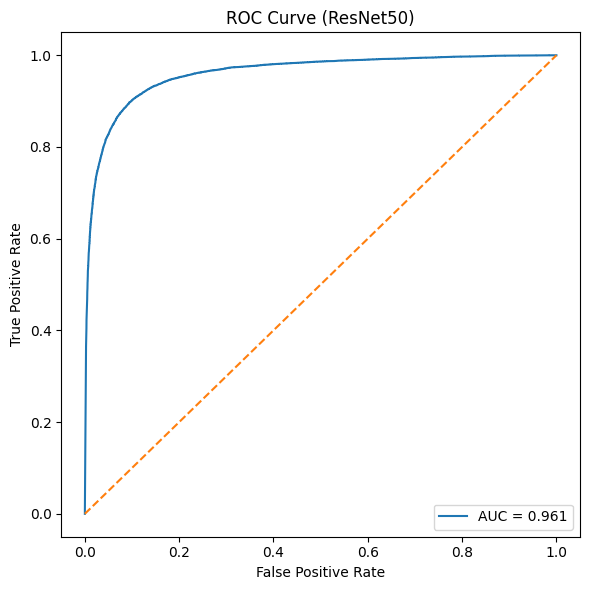

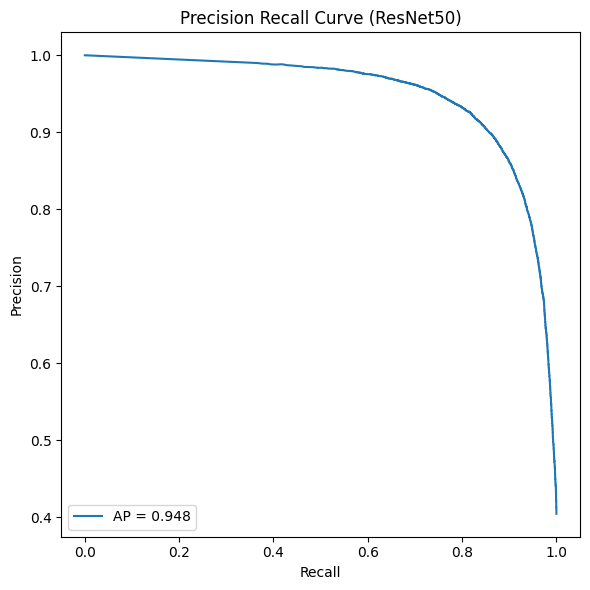

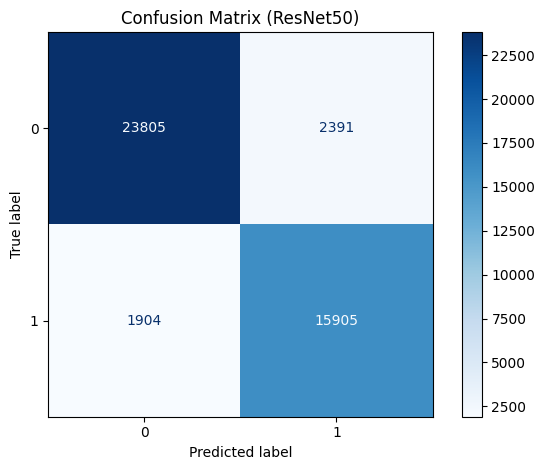

In [ ]:
# Final metrics on validation
resnet_model = build_resnet50_model(fine_tune_last_block=True)

# Load best checkpoint if saved
if os.path.exists(best_resnet_path):
    ckpt = torch.load(best_resnet_path, map_location=device)
    resnet_model.load_state_dict(ckpt["model"])
    print(f"Loaded best ResNet50 checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")

val_loss_rn, val_acc_rn, val_auc_rn = evaluate(resnet_model, valloader_resnet, criterion_resnet, device)
print(f"[ResNet50] val_loss: {val_loss_rn:.4f}  val_acc: {val_acc_rn:.4f}  val_auc: {val_auc_rn:.4f}")

# Curves & confusion matrix for ResNet50
probs_all_rn, y_all_rn = collect_probs_and_labels(resnet_model, valloader_resnet, device)


# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = roc_auc_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet50)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Precision–Recall Curve ---
prec, rec, _ = precision_recall_curve(y_all, probs_all)
ap = average_precision_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve (ResNet50)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
y_pred = (probs_all >= 0.5).astype(int)

cm = confusion_matrix(y_all, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix (ResNet50)")
plt.tight_layout()
plt.show()


### Evaluation of ResNet50 (Transfer Learning)

The ResNet50 transfer learning model achieved a validation loss of **0.186**, with an accuracy of **95.7%** and an AUC of **0.989** after 10 epochs. Compared to the baseline SimpleCNN, this represents a notable improvement in both accuracy and AUC, showing the benefit of leveraging pretrained ImageNet features. The ROC curve confirms excellent discriminative ability, with the curve very close to the top-left corner and an AUC near 1.0. The Precision–Recall curve also demonstrates strong performance with an average precision of **0.948**, indicating reliable detection of positive cancer cases despite the dataset imbalance. The confusion matrix shows a large number of true positives and true negatives, with relatively fewer false predictions than SimpleCNN. Overall, ResNet50 clearly outperforms the simpler architecture, validating the effectiveness of transfer learning for this histopathological image classification task.

## Generate Submission File

In [27]:
@torch.no_grad()
def predict_to_csv(model, loader, device, out_csv, float_fmt="%.9f"):
    """
    Save PROBABILITIES for Kaggle submission.
    If `threshold` is provided, also return thresholded preds for analysis,
    but do NOT write them to the CSV.

    Returns:
        ids (list[str]), probs_all (list[float]))
    """
    model.eval()
    ids, probs_all = [], []

    use_amp = (device.type == "mps")
    for x, ids_batch in loader:
        x = x.to(device, non_blocking=False)
        if use_amp:
            with autocast("mps"):
                logits = model(x)
        else:
            logits = model(x)
        probs = torch.sigmoid(logits).squeeze(1).cpu().tolist()
        ids.extend(ids_batch)
        probs_all.extend(probs)

    # Always write probabilities for Kaggle
    df = pd.DataFrame({"id": ids, "label": probs_all})
    df.to_csv(out_csv, index=False, float_format=float_fmt)
    print(f"Saved probability submission: {out_csv}  (N={len(df)})")

    return ids, probs_all


### Simple CNN Model

In [ ]:
file_name_suffix = time.strftime("%Y%m%d-%H%M%S")

simple_val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])
if os.path.exists(best_cnn_path):
    ckpt = torch.load(best_cnn_path, map_location=device)
    simple_cnn_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best SimpleCNN checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")

test_ds_simple = ImageDataset(DATA_DIR, transform=simple_val_tf, label_df=None, data_type="test")
test_loader_simple = torch.utils.data.DataLoader(test_ds_simple, batch_size=64, shuffle=False, num_workers=0)

predict_to_csv(simple_cnn_model, test_loader_simple, device, f"./submissions/simplecnn-{file_name_suffix}.csv")

Loaded best SimpleCNN checkpoint (epoch=14, auc=0.9606)
Saved probability submission: ./submissions/simplecnn-20250824-031024.csv  (N=57458)


(['00006537328c33e284c973d7b39d340809f7271b',
  '0000ec92553fda4ce39889f9226ace43cae3364e',
  '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
  '000253dfaa0be9d0d100283b22284ab2f6b643f6',
  '000270442cc15af719583a8172c87cd2bd9c7746',
  '000309e669fa3b18fb0ed6a253a2850cce751a95',
  '000360e0d8358db520b5c7564ac70c5706a0beb0',
  '00040095a4a671280aeb66cb0c9231e6216633b5',
  '000698b7df308d75ec9559ef473a588c513a68aa',
  '0006e1af5670323331d09880924381d67d79eda0',
  '000997a6038fa7441aa0111ac456255060a354c4',
  '000c8db3e09f1c0f3652117cf84d78aae100e5a7',
  '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe',
  '000e6341cf18365d35b40f4991002fec8834afc0',
  '0010e2887e0b977fcdfdf4c50564fafbbc2b6208',
  '0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0',
  '001161a2eca200f565f12870048a78fa5b320dee',
  '0011807dd1e3306ff3f7a755fd3efbefa2901dce',
  '00118bec91b7fae175791896f7011ff506b3d7dd',
  '0011f0596a038fc8daec4fde71465e347515392e',
  '0014fdb3da986174f9a1d7ae95f3b75a2d025a57',
  '00153be8e27526f9c2f035aff25ca92

### ResNet50 Model

In [ ]:
resnet_model = build_resnet50_model(fine_tune_last_block=True)

# (Optional) Load best checkpoint if saved
if os.path.exists(best_resnet_path):
    ckpt = torch.load(best_resnet_path, map_location=device)
    resnet_model.load_state_dict(ckpt["model"])
    print(f"Loaded best ResNet50 checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")

# Test loader
test_ds_resnet = ImageDataset(data_dir=DATA_DIR, transform=resnet_val_tf, label_df=None, data_type="test")
test_loader_resnet = torch.utils.data.DataLoader(test_ds_resnet, batch_size=32, shuffle=False, num_workers=0)

predict_to_csv(resnet_model, test_loader_resnet, device, f"./submissions/resnet50-{file_name_suffix}.csv")

Loaded best ResNet50 checkpoint (epoch=10, auc=0.9892)
Saved probability submission: ./submissions/resnet50-20250824-013459.csv  (N=57458)


(['00006537328c33e284c973d7b39d340809f7271b',
  '0000ec92553fda4ce39889f9226ace43cae3364e',
  '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
  '000253dfaa0be9d0d100283b22284ab2f6b643f6',
  '000270442cc15af719583a8172c87cd2bd9c7746',
  '000309e669fa3b18fb0ed6a253a2850cce751a95',
  '000360e0d8358db520b5c7564ac70c5706a0beb0',
  '00040095a4a671280aeb66cb0c9231e6216633b5',
  '000698b7df308d75ec9559ef473a588c513a68aa',
  '0006e1af5670323331d09880924381d67d79eda0',
  '000997a6038fa7441aa0111ac456255060a354c4',
  '000c8db3e09f1c0f3652117cf84d78aae100e5a7',
  '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe',
  '000e6341cf18365d35b40f4991002fec8834afc0',
  '0010e2887e0b977fcdfdf4c50564fafbbc2b6208',
  '0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0',
  '001161a2eca200f565f12870048a78fa5b320dee',
  '0011807dd1e3306ff3f7a755fd3efbefa2901dce',
  '00118bec91b7fae175791896f7011ff506b3d7dd',
  '0011f0596a038fc8daec4fde71465e347515392e',
  '0014fdb3da986174f9a1d7ae95f3b75a2d025a57',
  '00153be8e27526f9c2f035aff25ca92

## Conclusion

In this project, I compared two approaches for histopathological cancer detection: a custom **SimpleCNN** trained from scratch and a **ResNet50 transfer learning** model fine-tuned on the dataset. The SimpleCNN provided a strong baseline, reaching an accuracy of about **90%** and an AUC of **0.961**, showing that even a relatively shallow CNN can capture important visual patterns. However, the ResNet50 transfer learning approach achieved significantly stronger results, with **95.7%** accuracy and an **AUC of 0.989**, confirming the advantage of leveraging pretrained representations from large-scale image data. While ResNet50 required more training time and computational resources, its performance gains demonstrate the effectiveness of transfer learning in medical imaging tasks.

To validate these results beyond the local dataset split, both models were submitted to the **Kaggle competition leaderboard**. The SimpleCNN achieved a public leaderboard AUC of **0.664**, while the ResNet50 reached a much higher AUC of **0.933** (private AUC **0.921**). This large performance gap highlights how transfer learning with deeper pretrained architectures generalizes much better to unseen test data.

![Kaggle Submission Results](kaggle-submission.png)

### Model Comparison

| Model        | Validation Accuracy | Validation AUC | Public AUC (Kaggle) | Private AUC (Kaggle) | Strengths                                    |
|--------------|---------------------|----------------|----------------------|-----------------------|----------------------------------------------|
| SimpleCNN    | 90.2%              | 0.961          | 0.664               | 0.549                | Fast to train, interpretable baseline        |
| ResNet50     | 95.7%              | 0.989          | 0.933               | 0.921                | High performance, benefits from transfer learning |

**Key takeaway:** Transfer learning with ResNet50 clearly outperforms the baseline SimpleCNN, both in local validation and on the Kaggle leaderboard. This demonstrates that while a simple CNN is useful as a baseline and for exploratory analysis, **ResNet50 (and transfer learning in general) is the more reliable and competitive choice for real-world deployment and competition settings**.